In [ ]:
import sys
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr, zscore, rankdata
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.nn import global_mean_pool
from torch_geometric_temporal.nn.recurrent import GConvGRU, DCRNN
from torch_geometric.utils import from_networkx, add_self_loops, to_undirected
from tqdm import tqdm
from torch.utils.data import Dataset
from torch_geometric.data import Dataset



In [ ]:
lines = []
with open('/content/drive/MyDrive/EP1.01.txt', 'r') as file:
    for line in file:
        lines.append(line)
print(len(lines))

910476


In [ ]:
print(lines[0])
print(lines[1])
print(lines[2])
print(lines[3])
print(lines[4])

67635	67635	EP	AF3	6	260	4395.384615,4382.564102,4377.435897,4387.179487,4395.897435,4398.461538,4396.923076,4391.794871,4391.282051,4395.897435,4398.974358,4396.410256,4392.820512,4392.820512,4395.384615,4398.974358,4394.358974,4381.538461,4376.410256,4383.589743,4387.179487,4388.717948,4397.948717,4401.538461,4397.948717,4398.974358,4398.974358,4395.897435,4396.923076,4398.461538,4397.948717,4396.410256,4391.794871,4389.743589,4389.743589,4385.641025,4387.692307,4393.846153,4389.743589,4381.025641,4377.948717,4378.461538,4377.435897,4385.128205,4393.333333,4389.230769,4382.564102,4378.974358,4375.384615,4378.461538,4386.153846,4389.230769,4393.846153,4390.256410,4374.871794,4367.692307,4374.871794,4384.615384,4390.769230,4394.358974,4390.769230,4382.051282,4381.025641,4385.641025,4376.923076,4365.641025,4373.333333,4377.948717,4365.128205,4363.589743,4375.897435,4374.358974,4368.205128,4373.333333,4378.461538,4375.897435,4374.358974,4376.410256,4377.435897,4376.410256,4370.256410,437

In [ ]:
split_ = lines[0].split()
for i in range(len(split_)):
    print(i, split_[i])

0 67635
1 67635
2 EP
3 AF3
4 6
5 260
6 4395.384615,4382.564102,4377.435897,4387.179487,4395.897435,4398.461538,4396.923076,4391.794871,4391.282051,4395.897435,4398.974358,4396.410256,4392.820512,4392.820512,4395.384615,4398.974358,4394.358974,4381.538461,4376.410256,4383.589743,4387.179487,4388.717948,4397.948717,4401.538461,4397.948717,4398.974358,4398.974358,4395.897435,4396.923076,4398.461538,4397.948717,4396.410256,4391.794871,4389.743589,4389.743589,4385.641025,4387.692307,4393.846153,4389.743589,4381.025641,4377.948717,4378.461538,4377.435897,4385.128205,4393.333333,4389.230769,4382.564102,4378.974358,4375.384615,4378.461538,4386.153846,4389.230769,4393.846153,4390.256410,4374.871794,4367.692307,4374.871794,4384.615384,4390.769230,4394.358974,4390.769230,4382.051282,4381.025641,4385.641025,4376.923076,4365.641025,4373.333333,4377.948717,4365.128205,4363.589743,4375.897435,4374.358974,4368.205128,4373.333333,4378.461538,4375.897435,4374.358974,4376.410256,4377.435897,4376.410256,4

In [ ]:
event = []
digit = []
pos = []
data = []
line_counter = 0

data_df = pd.DataFrame(columns=['event', 'digit', 'pos', 'data'])

for line in tqdm(lines):
    if line_counter<14_00:
        split_line = line.split()
        event.append(split_line[1])
        digit.append(split_line[4])
        pos.append(split_line[3])
        data.append(split_line[6])
        line_counter+=1

data_df['event'] = event
data_df['digit'] = digit
data_df['pos'] = pos
data_df['data'] = data

num_events = data_df['event'].unique()
print(len(num_events))

del lines, event, digit, pos, data, num_events

print(data_df.head())
print(data_df.shape)

100%|██████████| 910476/910476 [00:00<00:00, 2136330.83it/s]

100
   event digit  pos                                               data
0  67635     6  AF3  4395.384615,4382.564102,4377.435897,4387.17948...
1  67635     6   F7  4489.230769,4475.384615,4474.358974,4486.66666...
2  67635     6   F3  4538.461538,4528.717948,4524.615384,4526.15384...
3  67635     6  FC5  4207.692307,4205.641025,4200.512820,4194.35897...
4  67635     6   T7  4497.948717,4498.461538,4494.871794,4497.94871...
(1400, 4)


In [ ]:
data_df['data'] = data_df['data'].apply(lambda x: [float(i) for i in x.split(',')])
data_df['data'] = data_df['data'].apply(lambda x: x[:250])

data_df['event'] = data_df['event'].apply(float)
data_df['digit'] = data_df['digit'].apply(float)
data_df['digit'] = data_df['digit'].apply(lambda x: 10 if x == -1 else x)

scaler = StandardScaler()
data_df['data'] = data_df['data'].apply(lambda x: scaler.fit_transform(np.array(x).reshape(-1, 1)).flatten())

# data_df.to_csv('data_df.csv')

print(data_df.head(28))
print(data_df.shape)


      event  digit  pos                                               data
0   67635.0    6.0  AF3  [1.5117334887900957, 0.0028969608423875335, -0...
1   67635.0    6.0   F7  [-0.5110569685231766, -1.424867480940589, -1.4...
2   67635.0    6.0   F3  [1.831272419840326, 0.5895102211104829, 0.0666...
3   67635.0    6.0  FC5  [-0.48370417021379947, -0.7171521125532858, -1...
4   67635.0    6.0   T7  [-0.2266636017788633, -0.15704942594019763, -0...
5   67635.0    6.0   P7  [1.1214211545117634, -0.2501800935338261, 0.02...
6   67635.0    6.0   O1  [-1.9238444508499861, -2.0951461682495722, -2....
7   67635.0    6.0   O2  [1.6915508899076892, 0.23772891630692064, -0.8...
8   67635.0    6.0   P8  [2.4717122229053183, 1.2317228333687613, -1.17...
9   67635.0    6.0   T8  [0.08883067066939604, -0.48731170581079036, -0...
10  67635.0    6.0  FC6  [1.5418446665750436, 0.3781883287141746, -0.05...
11  67635.0    6.0   F4  [2.7010461668243484, 1.8452013738604272, 1.550...
12  67635.0    6.0   F8  

In [ ]:
pos_values = data_df['pos'].unique()
print(pos_values)
data_lengths = data_df['data'].apply(len)
unique_lengths = data_lengths.unique()
print(unique_lengths)
del data_lengths

['AF3' 'F7' 'F3' 'FC5' 'T7' 'P7' 'O1' 'O2' 'P8' 'T8' 'FC6' 'F4' 'F8' 'AF4']
[250]


In [ ]:
def calculate_correlation(series1, series2):
    return pearsonr(series1, series2)[0]

def calculate_euclidean(series1, series2):
    return euclidean(series1, series2)

def calculate_dtw(series1, series2):
    distance, path = fastdtw(series1, series2)
    return distance

probes = data_df['pos'].unique()
similarity_matrix_corr = pd.DataFrame(index=probes, columns=probes)
similarity_matrix_euc = pd.DataFrame(index=probes, columns=probes)
similarity_matrix_dtw = pd.DataFrame(index=probes, columns=probes)


for i, probe1 in enumerate(probes):
    for j, probe2 in enumerate(probes):
        if i < j:
            series1 = data_df[data_df['pos'] == probe1]['data'].iloc[0]
            series2 = data_df[data_df['pos'] == probe2]['data'].iloc[0]

            corr = calculate_correlation(series1, series2)
            euc = calculate_euclidean(series1, series2)
            dtw = calculate_dtw(series1, series2)

            similarity_matrix_corr.at[probe1, probe2] = corr
            similarity_matrix_euc.at[probe2, probe1] = euc
            similarity_matrix_dtw.at[probe1, probe2] = dtw

np.fill_diagonal(similarity_matrix_corr.values, 0)
np.fill_diagonal(similarity_matrix_euc.values, 0)
np.fill_diagonal(similarity_matrix_dtw.values, 0)

print(similarity_matrix_corr)
print(similarity_matrix_euc)
print(similarity_matrix_dtw)


     AF3        F7        F3       FC5        T7        P7        O1  \
AF3    0  0.120298  0.844614  0.460885  0.321127   0.49943 -0.274865   
F7   NaN         0 -0.007454  0.164885  0.111316  -0.40595  0.679203   
F3   NaN       NaN         0  0.456136  0.459106   0.61893 -0.304065   
FC5  NaN       NaN       NaN         0  0.257494  0.142621   0.19319   
T7   NaN       NaN       NaN       NaN         0  0.627695 -0.146403   
P7   NaN       NaN       NaN       NaN       NaN         0 -0.630926   
O1   NaN       NaN       NaN       NaN       NaN       NaN         0   
O2   NaN       NaN       NaN       NaN       NaN       NaN       NaN   
P8   NaN       NaN       NaN       NaN       NaN       NaN       NaN   
T8   NaN       NaN       NaN       NaN       NaN       NaN       NaN   
FC6  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
F4   NaN       NaN       NaN       NaN       NaN       NaN       NaN   
F8   NaN       NaN       NaN       NaN       NaN       NaN      

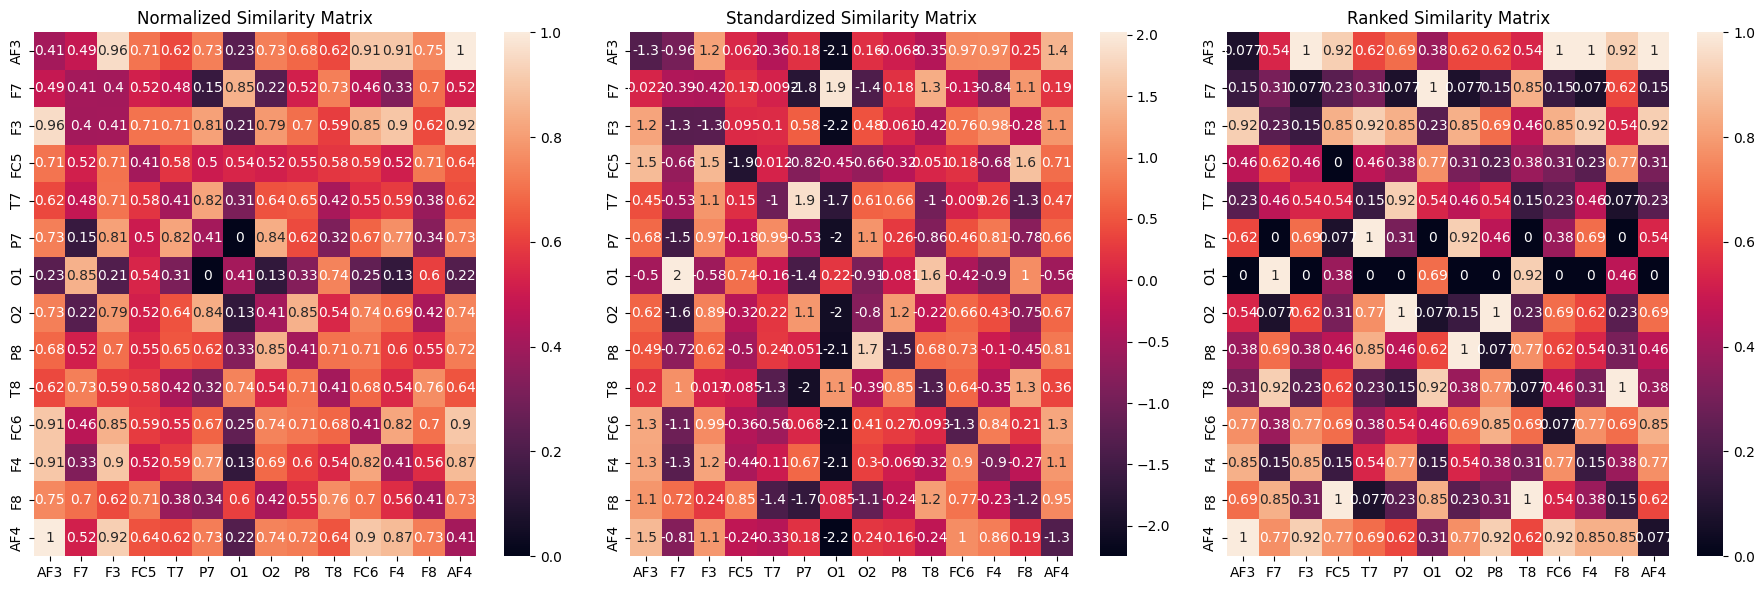

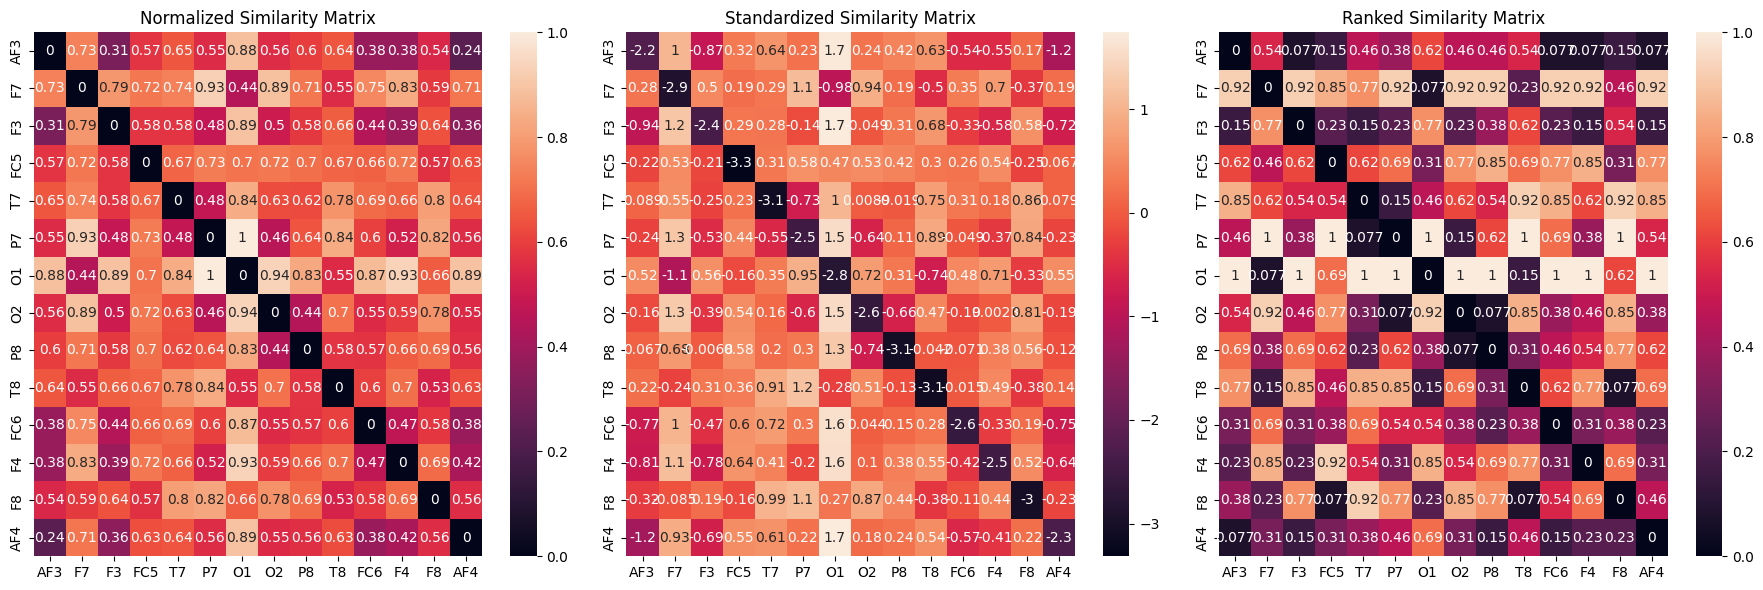

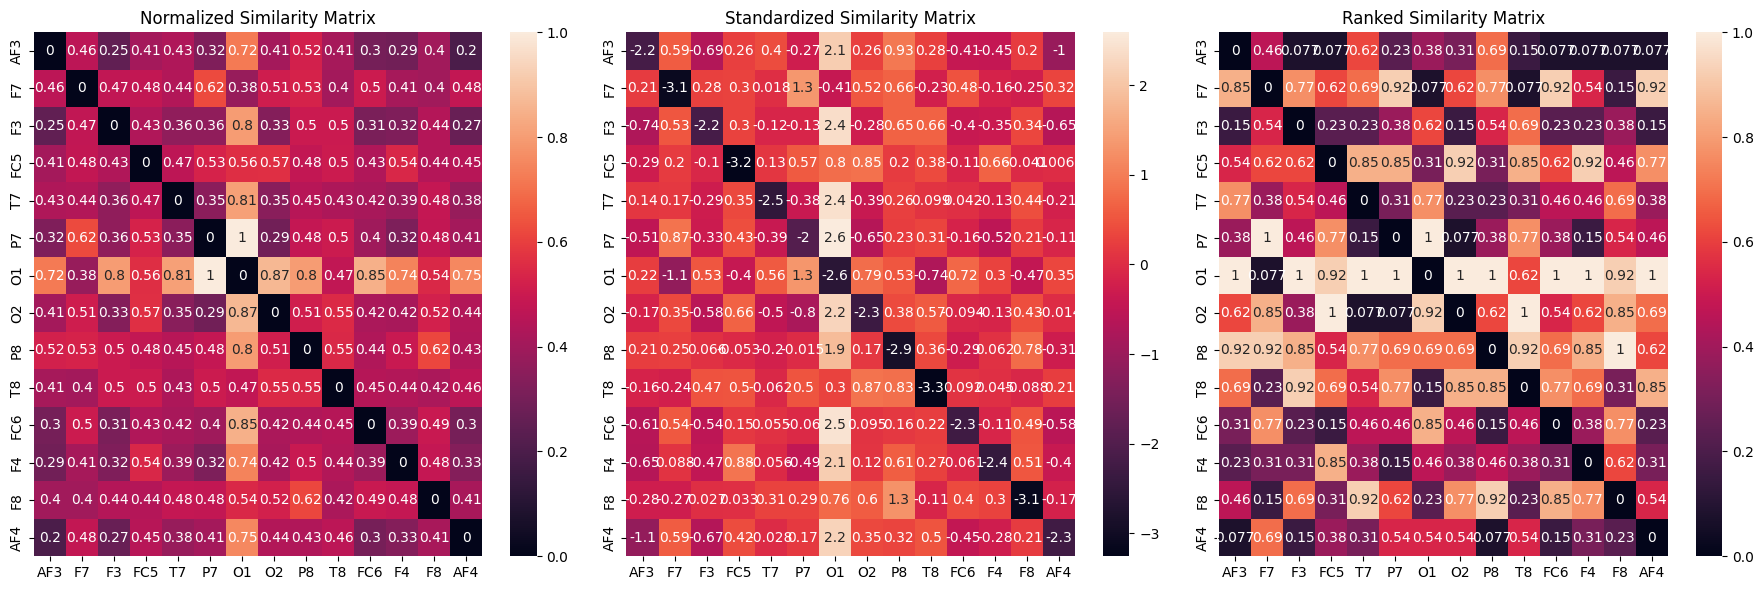

In [ ]:
def compare_sim_mat(similarity_matrix):
    similarity_matrix = similarity_matrix.apply(pd.to_numeric, errors='coerce')

    similarity_matrix = similarity_matrix.where(pd.notna(similarity_matrix), similarity_matrix.T)

    range_val = similarity_matrix.max().max() - similarity_matrix.min().min()
    if range_val == 0:
        normalized_matrix = similarity_matrix
    else:
        normalized_matrix = (similarity_matrix - similarity_matrix.min().min()) / range_val

    standardized_matrix = similarity_matrix.apply(lambda x: (x - x.mean()) / x.std(), axis=1)

    ranked_matrix = similarity_matrix.rank(method='average')
    ranked_matrix = (ranked_matrix - ranked_matrix.min().min()) / (ranked_matrix.max().max() - ranked_matrix.min().min())

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    sns.heatmap(normalized_matrix, annot=True, ax=axes[0])
    axes[0].set_title('Normalized Similarity Matrix')

    sns.heatmap(standardized_matrix, annot=True, ax=axes[1])
    axes[1].set_title('Standardized Similarity Matrix')

    sns.heatmap(ranked_matrix, annot=True, ax=axes[2])
    axes[2].set_title('Ranked Similarity Matrix')

    plt.tight_layout()
    plt.show()

compare_sim_mat(similarity_matrix_corr)
compare_sim_mat(similarity_matrix_euc)
compare_sim_mat(similarity_matrix_dtw)



In [ ]:
coordinates = {
    'AF3': {'phi': (129.9+89.7)/2,
            'theta': (52.2+41.0)/2},
    'F7': {'phi': 137.2,
            'theta': 83.1},
    'F3': {'phi': 129.9,
            'theta': 52.2},
    'FC5': {'phi': (137.2+129.9+173.9+180)/4 ,
            'theta': (83.1+52.2+95+45.2/4)},
    'T7': {'phi': 173.9,
            'theta': 95.0},
    'P7': {'phi': 216.1,
            'theta': 92.9},
    'O1': {'phi': 250.6,
            'theta': 89.2},
    'O2': {'phi': 287.5,
            'theta': 90.1},
    'P8': {'phi': 322.7,
            'theta': 94.9},
    'T8': {'phi': 3.2,
            'theta': 95.8},
    'FC6': {'phi': (-1.0+3.2+40.3+49.8)/4,
            'theta':(46.0+95.8+84.1+53.6)/4 },
    'F4': {'phi': 49.8,
            'theta': 53.6},
    'F8': {'phi': 40.3,
            'theta': 84.1},
    'AF4': {'phi': (89.7+49.8)/2,
            'theta': (41.0+53.6)/2}
}

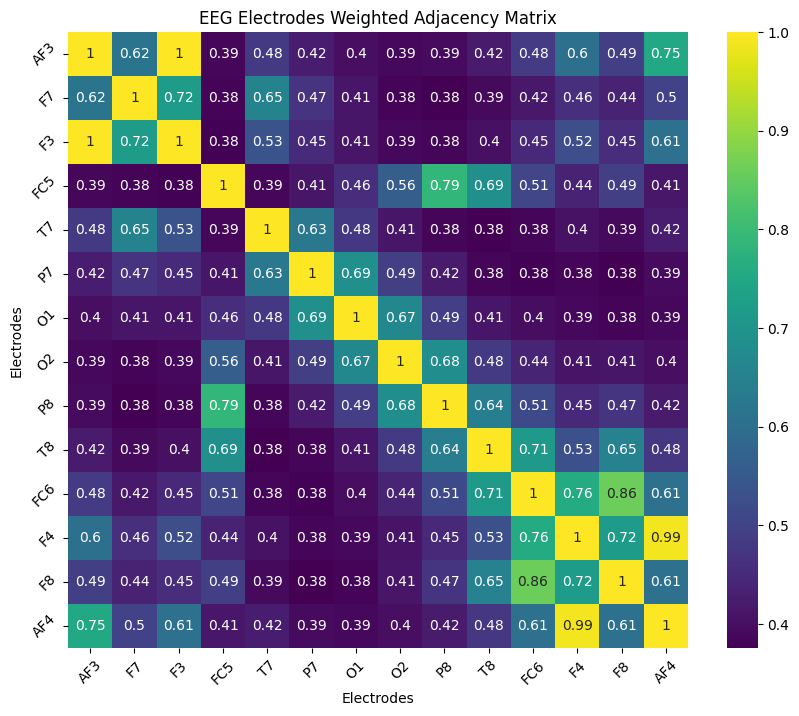

In [ ]:
def spherical_to_cartesian(phi, theta):
    phi_rad = np.radians(phi)
    theta_rad = np.radians(theta)
    x = np.cos(phi_rad) * np.sin(theta_rad)
    y = np.sin(phi_rad) * np.sin(theta_rad)
    z = np.cos(theta_rad)
    return x, y, z

adjacency_matrix = np.zeros((len(coordinates), len(coordinates)))

for i, (coord_i, values_i) in enumerate(coordinates.items()):
    x_i, y_i, z_i = spherical_to_cartesian(values_i['phi'], values_i['theta'])
    for j, (coord_j, values_j) in enumerate(coordinates.items()):
        if i != j:
            x_j, y_j, z_j = spherical_to_cartesian(values_j['phi'], values_j['theta'])
            d = np.sqrt((x_j - x_i) ** 2 + (y_j - y_i) ** 2 + (z_j - z_i) ** 2)
            w = 1 / np.sqrt(d)
            adjacency_matrix[i, j] = w

max_weight = adjacency_matrix.max()
adjacency_matrix[adjacency_matrix > 0] /= max_weight

np.fill_diagonal(adjacency_matrix, 1)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(adjacency_matrix, annot=True, cmap='viridis', ax=ax)

plt.title('EEG Electrodes Weighted Adjacency Matrix')
plt.xlabel('Electrodes')
plt.ylabel('Electrodes')
plt.xticks(ticks=np.arange(len(coordinates)) + 0.5, labels=list(coordinates.keys()), rotation=45)
plt.yticks(ticks=np.arange(len(coordinates)) + 0.5, labels=list(coordinates.keys()), rotation=45)

plt.show()


In [ ]:
def calculate_weights(coordinates):

    num_nodes = len(coordinates)
    adjacency_matrix = np.zeros((num_nodes, num_nodes))

    for i, coord_i in enumerate(coordinates.keys()):
        values_i = coordinates[coord_i]
        x_i, y_i, z_i = spherical_to_cartesian(values_i['phi'], values_i['theta'])
        for j, coord_j in enumerate(coordinates.keys()):
            if i != j:
                values_j = coordinates[coord_j]
                x_j, y_j, z_j = spherical_to_cartesian(values_j['phi'], values_j['theta'])
                d = np.sqrt((x_j - x_i) ** 2 + (y_j - y_i) ** 2 + (z_j - z_i) ** 2)
                w = 1 / d
                adjacency_matrix[i, j] = w

    max_weight = adjacency_matrix.max()
    adjacency_matrix[adjacency_matrix > 0] /= max_weight
    np.fill_diagonal(adjacency_matrix, 1)

    return adjacency_matrix



In [ ]:
class EEGGraphDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, edge_index, edge_weight):
        self.dataframe = dataframe
        self.edge_index = edge_index
        self.edge_weight = edge_weight
        self.edge_index = to_undirected(self.edge_index)
        self.edge_index, _ = add_self_loops(self.edge_index)
        self.unique_events = dataframe['event'].unique()

    def __len__(self):
        return len(self.unique_events)

    def __getitem__(self, idx):
        event_id = self.unique_events[idx]
        event_data = self.dataframe[self.dataframe['event'] == event_id]
        sequence = []
        for time_step in range(len(event_data.iloc[0]['data'])):
            x = torch.tensor([row.data[time_step] for row in event_data.itertuples(index=False)], dtype=torch.float).unsqueeze(1)
            snapshot = Data(x=x, edge_index=self.edge_index, edge_attr=self.edge_weight)
            sequence.append(snapshot)
        label = event_data.iloc[0]['digit']
        return sequence, label


In [ ]:
def collate_graph_sequences(batch):
    sequences, labels = zip(*batch)
    batched_sequences = [Batch.from_data_list(sequence) for sequence in sequences]
    return batched_sequences, torch.tensor(labels)


In [ ]:
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in globals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, size))


                       data_df:  3073544
        similarity_matrix_corr:     8402
         similarity_matrix_euc:     7674
         similarity_matrix_dtw:     7674
                          _i27:     3335
                          _i26:     3332
                          line:     3149
                          _i23:     2546
             batched_sequences:     2200
                       series1:     2112


In [ ]:
from torch.utils.data import Subset

def custom_train_test_split(dataset, test_size=0.2, random_state=42):
    np.random.seed(random_state)

    indices = np.arange(len(dataset))
    print(indices.size)
    np.random.shuffle(indices)

    split_idx = int(len(dataset) * (1 - test_size))
    print(split_idx)

    train_indices, test_indices = indices[:split_idx], indices[split_idx:]

    print('split done')

    train_dataset = Subset(dataset, train_indices)
    print(train_dataset)
    test_dataset = Subset(dataset, test_indices)
    print(test_dataset)

    return train_dataset, test_dataset

In [ ]:
print(type(adjacency_matrix))

<class 'numpy.ndarray'>


In [ ]:
# import networkx as nx
# import numpy as np
# import torch
# from scipy.spatial.distance import pdist, squareform

# def spherical_to_cartesian(phi, theta):
#     phi_rad = np.radians(phi)
#     theta_rad = np.radians(theta)
#     x = np.cos(phi_rad) * np.sin(theta_rad)
#     y = np.sin(phi_rad) * np.sin(theta_rad)
#     z = np.cos(theta_rad)
#     return x, y, z

# def calculate_knn_graph(coordinates, k=5):
#     positions = [spherical_to_cartesian(coord['phi'], coord['theta']) for coord in coordinates.values()]
#     distance_matrix = squareform(pdist(positions))
#     knn_graph = nx.Graph()

#     for i, coord_i in enumerate(coordinates):
#         distances = distance_matrix[i]
#         nearest_indices = np.argsort(distances)[1:k+1]
#         for j in nearest_indices:
#             distance = distances[j]
#             weight = 1 / distance
#             knn_graph.add_edge(coord_i, list(coordinates.keys())[j], weight=weight)

#     for coord in coordinates:
#         knn_graph.add_edge(coord, coord, weight=1.0)

#     return knn_graph

# knn_graph = calculate_knn_graph(coordinates, k=5)

# print(knn_graph)

# edge_indices = []
# edge_weights = []

# for u, v, data in knn_graph.edges(data=True):
#     if u != v:
#         index_u = list(coordinates.keys()).index(u)
#         index_v = list(coordinates.keys()).index(v)
#         weight = data['weight']

#         edge_indices.extend([[index_u, index_v], [index_v, index_u]])
#         edge_weights.extend([weight, weight])

# for i in range(len(coordinates)):
#     edge_indices.append([i, i])
#     edge_weights.append(1.0)

# edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
# edge_weight = torch.tensor(edge_weights, dtype=torch.float)

# print(edge_index.shape)
# print(edge_weight.shape)

# eeg_dataset = EEGGraphDataset(data_df, edge_index, edge_weight)

# print(eeg_dataset[1])

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)

# for name, size in sorted(((name, sys.getsizeof(value)) for name, value in globals().items()),
#                         key= lambda x: -x[1])[:10]:
#     print("{:>30}: {:>8}".format(name, size))

# train_dataset, test_dataset = custom_train_test_split(eeg_dataset, test_size=0.2, random_state=42)

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_graph_sequences)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_graph_sequences)


In [ ]:
G = nx.complete_graph(14)
edge_index = from_networkx(G).edge_index

weights = calculate_weights(coordinates)
edge_weights = torch.tensor(weights, dtype=torch.float)

eeg_dataset = EEGGraphDataset(data_df, edge_index, edge_weights)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in globals().items()),
                        key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, size))

train_dataset, test_dataset = custom_train_test_split(eeg_dataset, test_size=0.2, random_state=42)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_graph_sequences)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_graph_sequences)

del data_df

cuda
                       data_df:  3073544
        similarity_matrix_corr:     8402
         similarity_matrix_euc:     7674
         similarity_matrix_dtw:     7674
                          _i27:     3335
                          _i26:     3332
                          line:     3149
                            _i:     2546
                          _i23:     2546
                          _i55:     2546
100
80
split done


In [ ]:
class GRU(torch.nn.Module):
    def __init__(self, node_features):
        super(GRU, self).__init__()
        self.recurrent1 = GConvGRU(node_features, 64, 2)
        self.recurrent2 = GConvGRU(64, 32, 2)
        self.recurrent3 = GConvGRU(32, 16, 2)
        self.recurrent4 = GConvGRU(16, 8, 2)
        self.linear = torch.nn.Linear(8, 11)

    def forward(self, x, edge_index, edge_weight, batch):
        h = self.recurrent1(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.recurrent2(h, edge_index, edge_weight)
        h = F.relu(h)
        h = self.recurrent3(h, edge_index, edge_weight)
        h = F.relu(h)
        h = self.recurrent4(h, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        graph_output = global_mean_pool(h, batch)
        return graph_output

class DC(torch.nn.Module):
    def __init__(self, node_features):
        super(DC, self).__init__()
        self.recurrent1 = DCRNN(node_features, 32, 1)
        self.recurrent2 = DCRNN(32, 16, 1)
        self.recurrent3 = DCRNN(16, 16, 1)
        self.linear = torch.nn.Linear(16, 11)

    def forward(self, x, edge_index, edge_weight, batch):
        h = self.recurrent1(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.recurrent2(h, edge_index, edge_weight)
        h = F.relu(h)
        h = self.recurrent3(h, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        graph_output = global_mean_pool(h, batch)
        return graph_output


In [ ]:
print(device)

num_epochs = 100
node_features = 1

model = GRU(node_features).to(device)  # or DC(node_features)

optimizer = Adam(model.parameters(), lr=0.01)
criterion = CrossEntropyLoss()

def calculate_accuracy(y_pred, y_true):
    predicted = torch.argmax(y_pred, 1)
    correct = (predicted == y_true).float().sum()
    return (correct / y_true.shape[0]).item()

for epoch in tqdm(range(num_epochs)):
    model.train()
    total_loss = 0
    total_correct = 0
    all_labels = []
    all_preds = []

    for batched_sequences, labels in tqdm(train_loader):
        optimizer.zero_grad()
        sequence_outputs = []

        for sequence in batched_sequences:
          sequence.x = sequence.x.to(device)
          sequence.edge_index = sequence.edge_index.to(device)
          sequence.edge_weight = sequence.edge_attr.view(-1).to(device)
          sequence.batch = sequence.batch.to(device)
          graph_output = model(sequence.x, sequence.edge_index, sequence.edge_weight, sequence.batch)
          sequence_outputs.append(graph_output)

        sequence_outputs = torch.stack(sequence_outputs).mean(dim=0)
        labels = labels.to(device)
        labels = labels.long()
        loss = criterion(sequence_outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Calculate accuracy
        total_correct += calculate_accuracy(sequence_outputs, labels)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(torch.argmax(sequence_outputs, 1).cpu().numpy())

    train_accuracy = total_correct / len(train_loader)
    train_confusion_matrix = confusion_matrix(all_labels, all_preds)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}, Train Accuracy: {train_accuracy}")
    print("Train Confusion Matrix:\n", train_confusion_matrix)

    # Validation
    model.eval()
    test_loss = 0
    total_correct = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batched_sequences, labels in test_loader:
            sequence_outputs = []

            for sequence in batched_sequences:
              sequence.x = sequence.x.to(device)
              sequence.edge_index = sequence.edge_index.to(device)
              sequence.edge_weight = sequence.edge_attr.view(-1).to(device)
              sequence.batch = sequence.batch.to(device)
              graph_output = model(sequence.x, sequence.edge_index, sequence.edge_weight, sequence.batch)
              sequence_outputs.append(graph_output)

            sequence_outputs = torch.stack(sequence_outputs).mean(dim=0)
            labels = labels.to(device)
            labels = labels.long()
            loss = criterion(sequence_outputs, labels)
            test_loss += loss.item()

            # Calculate accuracy
            total_correct += calculate_accuracy(sequence_outputs, labels)
            # all_labels.extend(labels.cpu().numpy())
            # all_preds.extend(torch.argmax(sequence_outputs, 1).cpu().numpy())

    test_accuracy = total_correct / len(test_loader)
    # test_confusion_matrix = confusion_matrix(all_labels, all_preds)
    print(f"Test Loss: {test_loss/len(test_loader)}, Test Accuracy: {test_accuracy}")
    # print("Test Confusion Matrix:\n", test_confusion_matrix)


cuda


100%|██████████| 2/2 [00:27<00:00, 13.75s/it]


Epoch 1/100, Loss: 2.388882637023926, Train Accuracy: 0.1171875
Train Confusion Matrix:
 [[ 0  0  0  0  0  0  0  0  0  8]
 [ 0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0  9]
 [ 0  0  0  0  0  0  0  0  0  9]
 [ 0  0  0  0  0  0  0  0  0  2]
 [ 0  0  0  0  0  0  0  0  0  7]
 [ 0  0  0  0  0  0  0  0  0  9]
 [ 0  0  0  0  0  0  0  0  0  8]
 [ 0  0  0  0  0  0  0  0  0 12]
 [ 0  0  0  0  0  0  0  0  0  6]]


  1%|          | 1/100 [00:37<1:01:36, 37.33s/it]

Test Loss: 2.327052593231201, Test Accuracy: 0.10000000149011612



100%|██████████| 2/2 [00:27<00:00, 13.74s/it]


Epoch 2/100, Loss: 2.388305902481079, Train Accuracy: 0.1875
Train Confusion Matrix:
 [[ 0  0  0  0  0  0  0  0  8  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0  9  0]
 [ 0  0  0  0  0  0  0  0  9  0]
 [ 0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  7  0]
 [ 0  0  0  0  0  0  0  0  9  0]
 [ 0  0  0  0  0  0  0  0  8  0]
 [ 0  0  0  0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0  0  0  6  0]]


  2%|▏         | 2/100 [01:14<1:00:36, 37.11s/it]

Test Loss: 2.3242604732513428, Test Accuracy: 0.10000000149011612



100%|██████████| 2/2 [00:27<00:00, 13.92s/it]


Epoch 3/100, Loss: 2.394334077835083, Train Accuracy: 0.1640625
Train Confusion Matrix:
 [[ 0  0  0  0  0  0  0  0  8  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0  9  0]
 [ 0  0  0  0  0  0  0  0  9  0]
 [ 0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  7  0]
 [ 0  0  0  0  0  0  0  0  9  0]
 [ 0  0  0  0  0  0  0  0  8  0]
 [ 0  0  0  0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0  0  0  6  0]]


  3%|▎         | 3/100 [01:51<1:00:09, 37.21s/it]

Test Loss: 2.321610450744629, Test Accuracy: 0.10000000149011612



  3%|▎         | 3/100 [02:09<1:09:48, 43.18s/it]


KeyboardInterrupt: ignored